<section style="background-color: #21222c; padding: 1em">
    <h1><img alt="QuestDB Logo" src="https://play.questdb.io/questdb-logo.svg" width="305px"/></h1>
    <h2 style="color: white;">Interactive Notebook Session - Let's Play</h2>
</section>

## Exploring the dataset

The Open Power System Data (OPSD) hosts aggregated data about the energy landscape in some European countries. One of the datasets they curate contains energy data in 15 minutes intervals for Austria, Belgium, Germany, Hungary, Luxembourg, and Netherlands. The original can be found at <a href="https://data.open-power-system-data.org/time_series/" target="_blank">https://data.open-power-system-data.org/time_series/</a>. We are providing a derivative dataset containing only two years of data (**413383** rows) and four columns:

* Timestamp of the measure, in UTC timezone
* Actual total load in MW
* Forecasted energy for the same period, one day ahead, in MW
* Country code


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import psycopg
import questdb.ingress as qi

In [69]:
# This demo relies on dynamic network ports for the core endpoints. Do not change this values
http_port = 58993  # Web Console and REST API
ilp_port = 58991  # Fast data ingestion port 
pg_port = 58992  # PostgreSQL-compatible endpoint

In [70]:
df = pd.read_parquet('energy.parquet.gzip')

In [71]:
df.dtypes #column names and types

timestamp        datetime64[ns]
load_actual             float64
load_forecast           float64
country_code             object
dtype: object

In [72]:
df

,timestamp,load_actual,load_forecast,country_code
105220,2018-01-01 00:00:00,6060.40,6497.24,AT
105221,2018-01-01 00:15:00,5971.20,6399.35,AT
105222,2018-01-01 00:30:00,5875.20,6321.08,AT
105223,2018-01-01 00:45:00,5830.80,6252.09,AT
105224,2018-01-01 01:00:00,5872.00,6328.14,AT
...,...,...,...,...
175295,2019-12-31 22:45:00,11284.98,9672.61,NL
175296,2019-12-31 23:00:00,11185.59,9573.25,NL
175297,2019-12-31 23:15:00,11207.35,9593.16,NL
175298,2019-12-31 23:30:00,11237.45,9583.39,NL


country_code
AT    AxesSubplot(0.125,0.11;0.775x0.77)
BE    AxesSubplot(0.125,0.11;0.775x0.77)
DE    AxesSubplot(0.125,0.11;0.775x0.77)
HU    AxesSubplot(0.125,0.11;0.775x0.77)
LU    AxesSubplot(0.125,0.11;0.775x0.77)
NL    AxesSubplot(0.125,0.11;0.775x0.77)
Name: load_actual, dtype: object

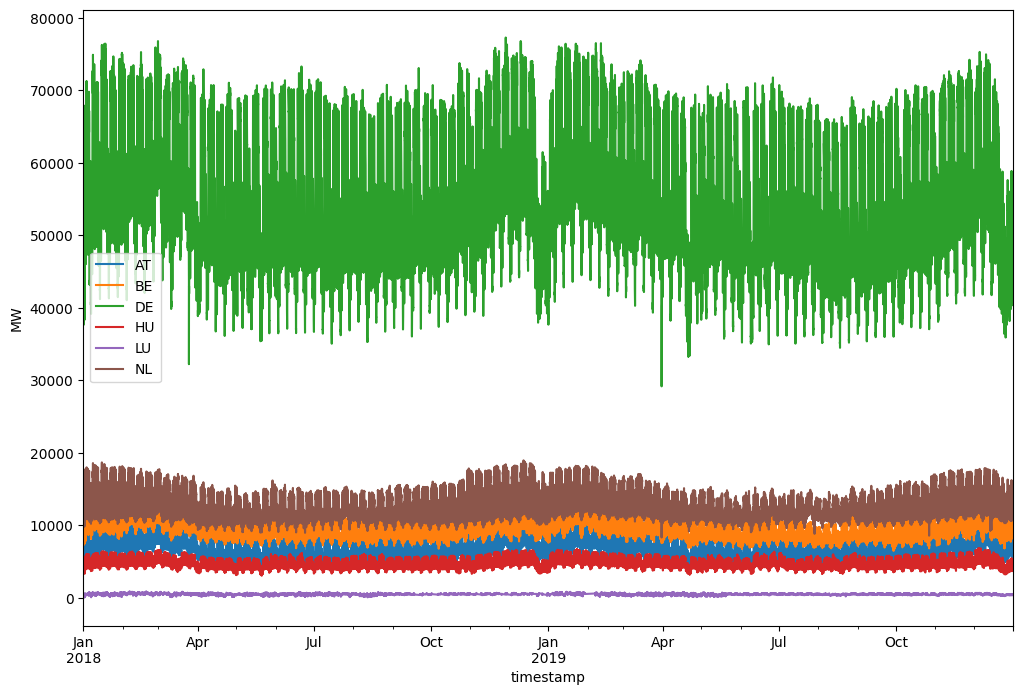

In [119]:
plt.figure(figsize=(12,8))
df.set_index('timestamp').groupby('country_code')['load_actual'].plot(legend=True, ylabel="MW")

## Inserting your dataframe into QuestDB

To ingest your dataframe into QuestDB, you use the Sender object. We need to specify the table name and the name of the column that will be the designated timestamp. If you don't specify one, ingestion time will be used. If the table doesn't exist, it will be automatically created.

In [75]:
with qi.Sender('localhost', ilp_port) as sender:
  sender.dataframe(df, table_name='energy_total', at='timestamp')
  

## Reading data

A good way of reading data is by using Psycopg and connecting to QuestDB using the postgres protocol.

In [76]:
qdb_conn_params = dict(user="admin", password="quest", host='127.0.0.1', port=pg_port, dbname="qdb")

In [120]:
with psycopg.connect(**qdb_conn_params) as conn:
    with conn.cursor() as cur:
        cur.execute("""\
                    SELECT timestamp, 
                    country_code, 
                    SUM(load_actual) as total_mw,                      
                    avg(load_actual) as average_mw 
                    FROM energy_total 
                    SAMPLE by 6M -- We downsample/aggregate to 6M periods
                    """)
        records = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]

res_df = pd.DataFrame(records, columns= column_names )

In [78]:
res_df #now we have only 24 rows (4 semesters, 6 countries)

,timestamp,country_code,total_mw,average_mw
0,2018-01-01,HU,8.685141e+07,4998.354505
1,2018-01-01,LU,8.189809e+06,471.328803
2,2018-01-01,NL,2.278702e+08,13114.076830
3,2018-01-01,DE,9.992771e+08,57509.038702
4,2018-01-01,BE,1.772776e+08,10202.440696
5,2018-01-01,AT,1.285705e+08,7399.313283
6,2018-07-01,HU,8.638703e+07,4890.570046
7,2018-07-01,LU,5.932631e+06,466.805487
8,2018-07-01,NL,2.310148e+08,13078.281776
9,2018-07-01,BE,1.726742e+08,9775.484108


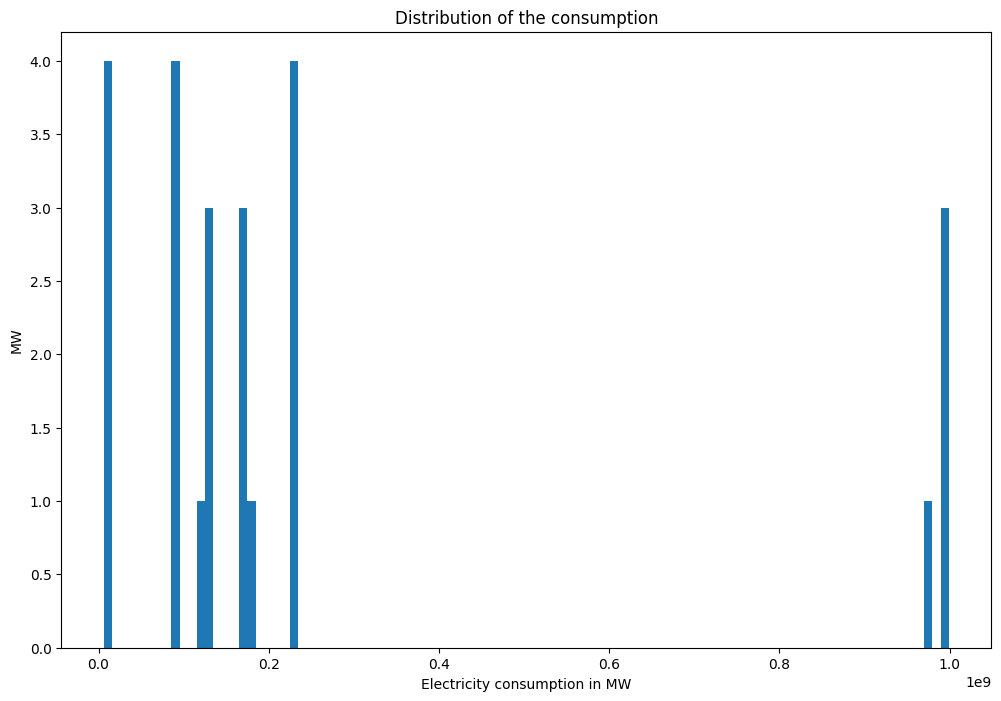

In [121]:
# of course once your results come back from QuestDB and converted into a DataFrame, just use them as usual
plt.figure(figsize=(12,8))
plt.hist(res_df['total_mw'], bins=100)
plt.title("Distribution of the consumption")
plt.xlabel("Electricity consumption in MW")
plt.ylabel("MW")
plt.show()

## Finding (and interpolating) missing data

In [122]:
with psycopg.connect(**qdb_conn_params) as conn:
    with conn.cursor() as cur:
        cur.execute("""\
                    WITH de_data AS (
                        SELECT timestamp, SUM(load_actual) AS load_actual 
                        FROM 'energy_total' 
                        WHERE country_code = 'DE' SAMPLE BY 15m FILL(null) 
                        -- FILL allows to find gaps when there are no rows for a particular interval
                    ) 
                    SELECT * FROM de_data WHERE load_actual IS NULL
                    """)
        records = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]

res_df = pd.DataFrame(records, columns= column_names )
res_df #you can play with other countries, for example AT or LU to see if you can find any missing rows



,timestamp,load_actual
0,2018-09-23 22:00:00,None
1,2018-09-23 22:15:00,None
2,2018-09-23 22:30:00,None
3,2018-09-23 22:45:00,None
4,2018-09-23 23:00:00,None
...,...,...
91,2018-09-24 20:45:00,None
92,2018-09-24 21:00:00,None
93,2018-09-24 21:15:00,None
94,2018-09-24 21:30:00,None


In [123]:
with psycopg.connect(**qdb_conn_params) as conn:
    with conn.cursor() as cur:
        cur.execute("""\
                    WITH interpolated_de_data AS (
                        SELECT timestamp, SUM(load_actual) AS load_actual 
                        FROM 'energy_total' 
                        WHERE country_code = 'DE' 
                        SAMPLE BY 15m FILL(PREV) 
                        -- FILL also allows to use LINEAR interpolation, PREVious value, NULL, or a constant
                    ) 
                    SELECT * FROM interpolated_de_data WHERE timestamp > '2018-09-23T21'
                    """)
        records = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]

res_df = pd.DataFrame(records, columns= column_names )
res_df #you can play with other countries, for example AT or LU to see if you can find any missing rows

,timestamp,load_actual
0,2018-09-23 21:15:00,46217.76
1,2018-09-23 21:30:00,45652.85
2,2018-09-23 21:45:00,44764.59
3,2018-09-23 22:00:00,44764.59
4,2018-09-23 22:15:00,44764.59
...,...,...
44550,2019-12-31 22:45:00,43445.02
44551,2019-12-31 23:00:00,42783.12
44552,2019-12-31 23:15:00,42373.87
44553,2019-12-31 23:30:00,42102.83


## Downsampling, joining by time, then downsampling again

In [124]:
with psycopg.connect(**qdb_conn_params) as conn:
    with conn.cursor() as cur:
        cur.execute("""\
                    WITH germany_daily AS (
                        SELECT timestamp, SUM(load_forecast) AS daily_forecast, SUM(load_actual) AS daily_actual 
                        FROM 'energy_total' 
                        WHERE country_code = 'DE' 
                        SAMPLE BY 1d ALIGN TO CALENDAR 
                        -- load_forecast makes reference to same period next day. Here we get the total actual and next day forecast for each day
                        )
                    SELECT a.timestamp, SUM(a.daily_actual) AS load_mw, SUM(f.daily_forecast) AS forecast_mw 
                    FROM germany_daily a LT JOIN germany_daily f 
                    SAMPLE BY 7d -- Aggregate in 7d chunks
                    
                    -- LT JOIN joins each row in the left table with the row from the right table,
                    -- so we can compare daily_load for today with the forecasted_load we did yesterday 
                    
                    """)
        records = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]

res_df = pd.DataFrame(records, columns= column_names ).set_index('timestamp')

In [112]:
res_df #For each 7 day period we have now the actual_load, and the forecasted load for the same period

,load_mw,forecast_mw
timestamp,,
2018-01-01,3.686486e+07,31810285.68
2018-01-08,4.035499e+07,39780472.87
2018-01-15,4.157548e+07,42557206.23
2018-01-22,4.040618e+07,42150759.86
2018-01-29,4.086842e+07,41375370.38
...,...,...
2019-12-02,4.103186e+07,39503715.64
2019-12-09,4.115475e+07,40542337.96
2019-12-16,3.819430e+07,39659720.20


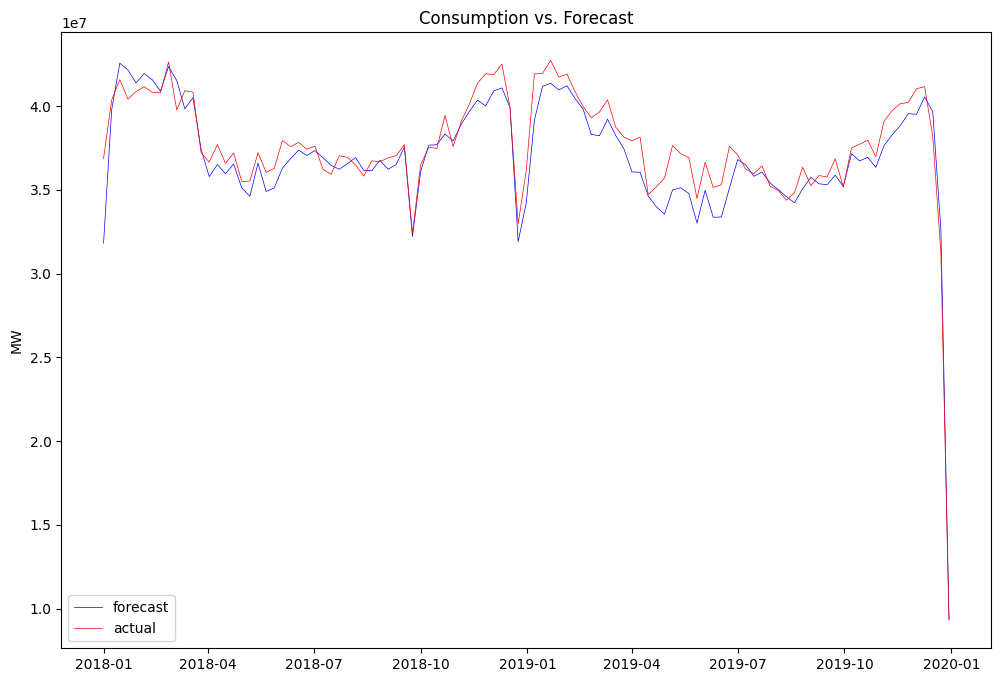

In [125]:
plt.figure(figsize=(12,8))
plt.plot(res_df['forecast_mw'], '-b', label='forecast', linewidth = 0.5)
ax=plt.plot(res_df['load_mw'], '-r', label='actual', linewidth = 0.5)
plt.title("Consumption vs. Forecast")
plt.legend(loc="lower left")
plt.ylabel('MW')
plt.show()

## Exploring Seasonality

In [126]:
 with psycopg.connect(**qdb_conn_params) as conn:
    with conn.cursor() as cur:
        cur.execute("""\
                    SELECT timestamp, month(timestamp) as month, to_str(timestamp, 'E') as day, 
                           SUM(load_forecast) AS daily_forecast, 
                           SUM(load_actual) AS daily_actual 
                    FROM 'energy_total' 
                    WHERE country_code = 'DE' 
                    SAMPLE BY 1d ALIGN TO CALENDAR 
                    """)
        records = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]

res_df = pd.DataFrame(records, columns= column_names )
    

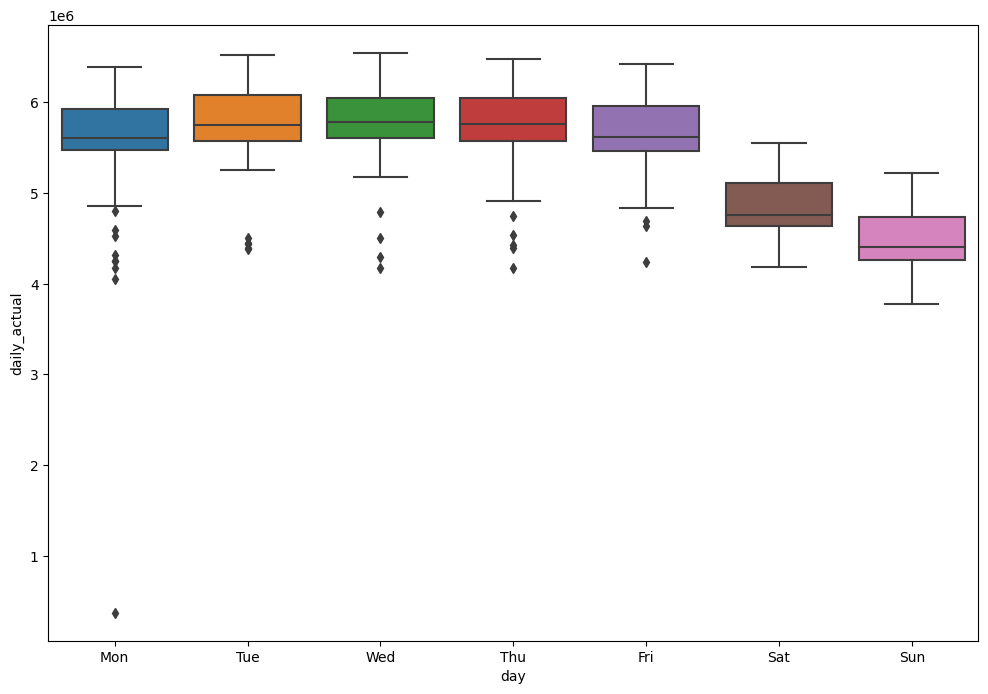

In [127]:
plt.figure(figsize=(12,8))
sns.boxplot(data=res_df, x='day', y='daily_actual')
plt.show() #there seem to be some daily patterns

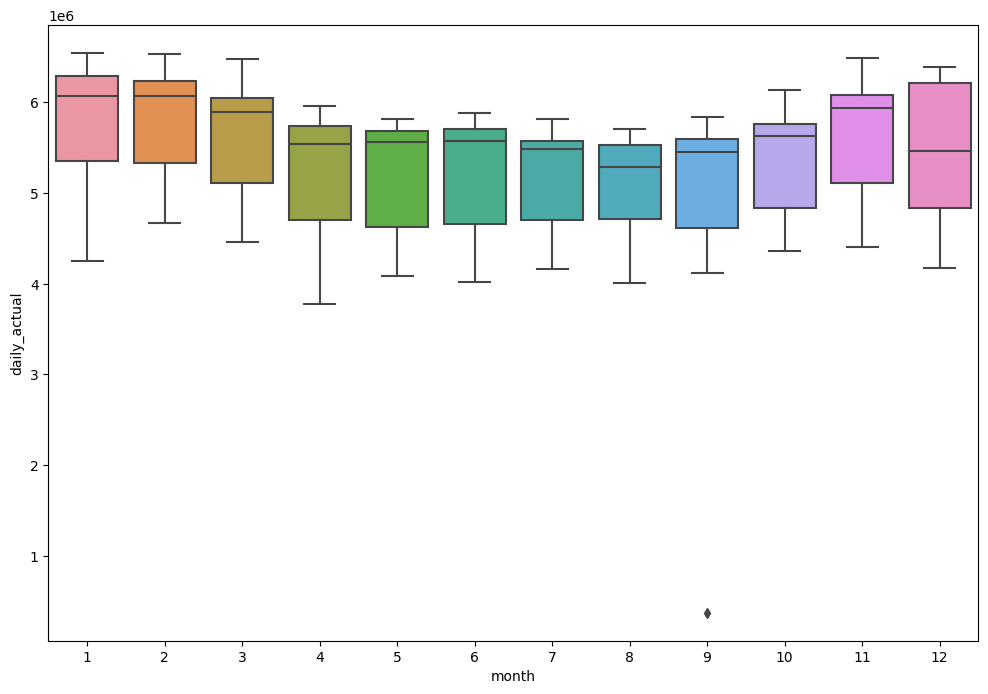

In [128]:
plt.figure(figsize=(12,8))
sns.boxplot(data=res_df, x='month', y='daily_actual')
plt.show() #patterns are clearer when checking by month

## Wrapping up

By adding QuestDB to your data science/interactive data workflows you can work at speed with time-series data, even if your dataset doesn't fit in memory. QuestDB executes outside your notebook environment, using parallelization, so you are not limited to the single-threaded nature of Pandas.

In this notebook we learnt how to:

* Ingest Pandas dataframes into QuestDB
* Execute filters, aggregations, and transforms directly on the database, with automatic parallelization and no memory restrictions
* Downsample and interpolate data at high speed
* Use SQL for a better developer experience

To learn more visit <a href="https://questdb.io" target="_blank">the QuestDB home</a> or to just execute some example queries on top of public datasets, hit the <a href="https://demo.questdb.io" target="_blank">live QuestDB demo</a>.

Keep playing!